**Name:** zhai qiuyu

**EID:** qiuyuzhai2

# CS5489 - Tutorial 6
## Using Deep Features

In this tutorial you will train a classifier to classify images with different types of cakes using deep features.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.transform

Second, initialize pytorch and its submodules

In [2]:
import torch
import logging
from torch import nn
from copy import deepcopy
logging.basicConfig()
import sys
from sklearn.preprocessing import LabelEncoder
from torchvision import models
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
print("Python:", sys.version, "Torch:", torch.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0] Torch: 2.8.0+cpu


## Loading Data and Pre-processing
Next we need to load the images.  Download `cakes.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [ ]:
imgdata = []
classes = []

# load the zip file
filename = '/content/cakes.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "cakes/*/*.jpg"):

        # filename is : cakes/class/file.jpg
        (fdir1, fname)  = os.path.split(name)  # 文件路径拆分为目录（路径前半部分）和文件名（路径最后一部分）
        (fdir2, fclass) = os.path.split(fdir1) # 再次拆分目录，得到类别名

        # open file in memory, and parse as an image
        myfile = zfile.open(name) # 打开压缩包（cakes.zip）里的某个文件（图片）
        # 这样可以直接在内存中读取图片内容，无需解压到磁盘
        #img = matplotlib.image.imread(myfile)
        img = skimage.io.imread(myfile) # 读取图片文件内容到一个数组中
        img2 = skimage.transform.resize(img, (224,224), anti_aliasing=False)

        myfile.close()

        imgdata.append(img2)
        classes.append(fclass)

zfile.close()
print(len(imgdata))
print(img.size)

800
589824


Each image is a 224x224. There are 8 classes of differerent cakes.  Run the below code to show examples of each class.

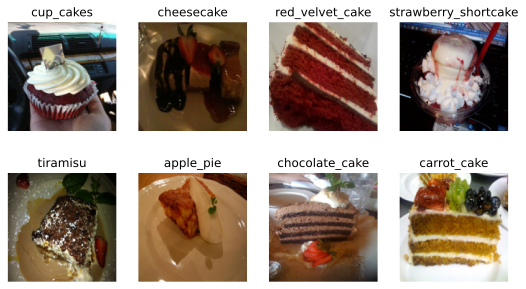

In [8]:
plt.figure(figsize=(9,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    ind = i*100
    plt.imshow(imgdata[ind])
    plt.title(classes[ind])
    plt.axis('off')
plt.show()

Next, store the images into a Tensor. ResNet assumes the data is [0,255] range, so we need to scale the images that were read in with skimage.

In [ ]:
# PyTorch version
Xraw = torch.zeros((len(imgdata), 3, 224, 224))
# 创建一个形状为（图片数量，3，224，224）的全0张量，3表示RGB通道，224x224是图片的尺寸

# Define preprocessing pipeline
preprocess = transforms.Compose([
    transforms.ToPILImage(),# 把 numpy 数组或 tensor 转为 PIL 图片格式
    transforms.Resize(224), # 调整图片大小为 224x224
    transforms.ToTensor(),   # 把 PIL 图片转为 tensor，并把像素值归一化到 [0,1] 范围
    transforms.Lambda(lambda x: x * 255) # 把像素值从 [0,1] 范围放大到 [0,255] 范围
])

for i, img in enumerate(imgdata): # 遍历每张图片
    x = np.array(img)  # 把图片转换为 numpy 数组
    x = preprocess(x) # 应用预处理管道
    Xraw[i] = x # 把预处理后的图片数据存入 Xraw 张量中

Finally, we convert the class label strings into class numbers.

In [ ]:
print("Class labels (strings):", np.unique(classes)) # 显示唯一的类别标签

le = LabelEncoder()  # 创建标签编码器
Y = le.fit_transform(classes) # 把字符串标签转换为整数标签
print("Converted labels:") 
print(Y)

Y_tensor = torch.LongTensor(Y) # 转换为 PyTorch 的 LongTensor 类型
Yb = torch.zeros(len(Y), len(le.classes_)) # 创建一个形状为（样本数量，类别数量）的全0张量
Yb.scatter_(1, Y_tensor.unsqueeze(1), 1) # 使用 scatter_ 方法进行 one-hot 编码

print("\nOne-hot encoded tensor:")
print(Yb)
print("Shape:", Yb.shape)

Class labels (strings): ['apple_pie' 'carrot_cake' 'cheesecake' 'chocolate_cake' 'cup_cakes'
 'red_velvet_cake' 'strawberry_shortcake' 'tiramisu']
Converted labels:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7

## Extract Deep features
Now preprocess the images in imdata and put them into a 4D tensor for ResNet.  Store it in a tensor `Xim`.  
Note that `preprocess_input` may overwrite its input data, so you may need to make a `copy` if you want to preserve `Xraw`.

In [15]:
### INSERT YOUR CODE HERE ###

In [18]:
# 修改: 图像预处理用于输入 ResNet（归一化并标准化到 ImageNet 统计）
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

# 将 Xraw 从 [0,255] 转成 [0,1] 再做标准化
Xim = (Xraw.clone() / 255.0 - imagenet_mean) / imagenet_std
print("Xim shape:", Xim.shape, "dtype:", Xim.dtype)

Xim shape: torch.Size([800, 3, 224, 224]) dtype: torch.float32


Extract features from Resnet50, call it `Xf`.

In [22]:
### INSERT YOUR CODE HERE ###

In [ ]:
# 修改: 使用预训练 ResNet50 提取 2048 维全局平均池化特征
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ResNet50 是一个经典的图像处理基底模型
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

resnet = resnet.to(device)
resnet.eval()

# resnet 的前向传播手动截取到全连接层之前：
with torch.no_grad():                # 关闭梯度计算，加速推理，节省显存
    batch_size = 64                  # 每次处理 64 张图片（批量处理，提升效率）
    feats = []                       # 用于收集所有图片的特征
    for start in range(0, Xim.shape[0], batch_size):   # 按批次遍历所有图片
        end = start + batch_size
        xb = Xim[start:end].to(device)                 # 取出当前批次图片，并放到 GPU 或 CPU
        x = resnet.conv1(xb)           # 第一层卷积
        x = resnet.bn1(x)              # 批归一化 # 对卷积输出进行批归一化
        x = resnet.relu(x)             # 激活函数
        x = resnet.maxpool(x)          # 最大池化
        x = resnet.layer1(x)           # 第一组残差块
        x = resnet.layer2(x)           # 第二组残差块
        x = resnet.layer3(x)           # 第三组残差块
        x = resnet.layer4(x)           # 第四组残差块
        x = resnet.avgpool(x)          # 全局平均池化，输出 [N,2048,1,1]，resnet规定的
        # fc 层被省略了，因为我们只需要特征，不需要分类结果
        x = torch.flatten(x, 1)        # 展平成 [N,2048]，每张图片一个 2048 维特征
        feats.append(x.cpu())          # 把特征搬到 CPU 并保存
    Xf = torch.cat(feats, dim=0)       # 拼接所有批次，得到完整特征张量

print("Extracted feature tensor Xf shape:", Xf.shape)


Extracted feature tensor Xf shape: torch.Size([800, 2048])


##  Train a classifier
Split the data into training and testing for the classifier.

In [ ]:
# randomly split data into train and test set
( trainXf, testXf,       # features
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)

print(trainXf.shape) # （样本数，特征维度）
print(testXf.shape)
print(trainY.shape) # （样本数，）
print(testY.shape)
# cleanup memory
del trainimgdata, Xraw

torch.Size([640, 2048])
torch.Size([160, 2048])
(640,)
(160,)


Now train a few traditional classifier (e.g, SVM, logistic regression, random forest, etc.) and compute the accuracy.

In [ ]:
### INSERT YOUR CODE HERE ###

In [ ]:
# 修改: 训练多种传统分类器并选择最佳（逻辑回归 / SVM / 随机森林）
from sklearn.preprocessing import StandardScaler      # 数据标准化（均值为0，方差为1）
from sklearn.pipeline import Pipeline                # 构建机器学习流水线（可串联预处理和模型）

from sklearn.metrics import accuracy_score           # 计算分类准确率

from sklearn.linear_model import LogisticRegression  # 逻辑回归分类器
from sklearn.svm import SVC                          # 支持向量机分类器
from sklearn.ensemble import RandomForestClassifier  # 随机森林分类器

trainXf_np = trainXf.numpy() # 把训练集的特征（PyTorch tensor 类型）转换为 numpy 数组，方便 sklearn 的传统机器学习模型使用。
testXf_np  = testXf.numpy()

# pipeline 常用于把数据预处理和模型训练串联起来，形成一个整体的工作流
classifiers = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()), # 数据标准化，这个是针对传统机器学习模型的，之前那些是针对神经网络的
        ("clf", LogisticRegression(max_iter=2000, multi_class='multinomial')) # clf 是 classifier 的缩写
    ]),
    "SVM_RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', C=5, gamma='scale'))
    ]),
    "RF": RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42) # 随机森林不需要标准化
}

best_name = None
best_acc = -1
best_clf = None

for name, clf in classifiers.items():
    clf.fit(trainXf_np, trainY) # 训练分类器
    pred = clf.predict(testXf_np) # 在测试集上预测
    acc = accuracy_score(testY, pred) # 计算准确率
    print(f"{name} accuracy: {acc:.4f}")  # 输出分类器名称和准确率
    
    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_clf = clf
        mypred = pred  # 保存最佳模型预测

print(f"Best classifier: {best_name}, accuracy={best_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg accuracy: 0.5750
SVM_RBF accuracy: 0.5375
RF accuracy: 0.6000
Best classifier: RF, accuracy=0.6000


## Analyze results

Run the below code to visualize the predictions on the test set.  `mypred` are the class predictions from your classifier.

In [ ]:
# get the class labels
# 把预测的整数标签和真实标签转换回字符串标签
predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")"
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off()
plt.show()

Now look at the confusion matrix

混淆矩阵（confusion matrix）是用来分析分类模型效果的一个表格。

它的每一行代表真实类别，每一列代表模型预测的类别。
对角线上的数字表示预测正确的数量，其他位置表示被误分类的数量。

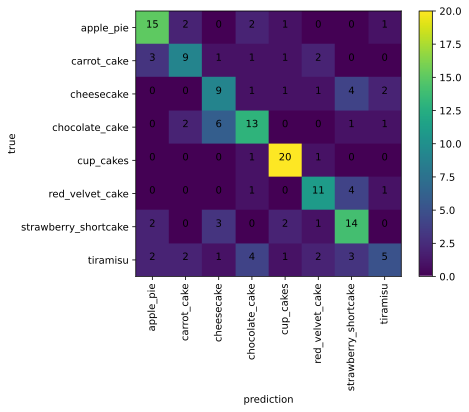

In [ ]:
CM = metrics.confusion_matrix(testY, mypred) # 表示真实类别是第 i 类，但被预测成第 j 类的样本数。

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')
plt.show()

越亮的地方，分类预测的越准确

_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**

Errors in traditional classifiers primarily occur between cake categories that share similar appearances or comparable textures/colors. For instance, two types featuring light-colored cream layers with sponge-like structures may be confused with each other. Additionally, cakes adorned with fruit garnishes can be misclassified as plain cream cakes when viewed from different angles or cropped differently. This indicates that fine-grained distinctions—such as local decorations and toppings—are not sufficiently captured when relying solely on global features combined with linear/kernel classifiers.

# Transfer learning

Try using a pre-trained network as the backbone for a new network. You can try some of the following:
- training an MLP classifier using the 2048 features from ResNet.
- using other networks (e.g., InceptionNet) to extract the features.
  - remember to change the pre-processing step too.
- using the a feature map (7x7x2048) and applying a small CNN.
- fine-tuning the whole network.

转移学习

- 尝试使用预训练网络作为新网络的骨干。你可以尝试以下方法：

- 用 ResNet 提取的 2048 维特征训练一个 MLP 分类器。
- 使用其他网络（例如 InceptionNet）来提取特征。
- 注意要更改预处理步骤。
- 使用特征图（7x7x2048），并加一个小型 CNN。
- 微调整个网络。

In [30]:
### INSERT YOUR CODE HERE ####

In [ ]:
# 新增: Transfer Learning 公共设置与工具函数
import torch
import torch           # PyTorch深度学习框架
import numpy as np     # 数值计算库，处理数组和矩阵
from torchvision import models, transforms  # 图像模型和预处理工具
from sklearn import metrics # 机器学习评估指标（如准确率、混淆矩阵等）
from torch import nn   # 神经网络模块（如MLP、CNN等）
import torch.optim as optim # 优化器（如Adam、SGD等）
from torch.utils.data import DataLoader    # 数据加载工具（批量训练用）

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(le.classes_)
print("Using device:", device)

# 统一的标签张量（便于 PyTorch 训练时索引）
trainY_t = torch.tensor(trainY)
testY_t = torch.tensor(testY)

# 评估工具
def eval_and_print(name, y_true, y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    print(f"[Eval] {name} accuracy: {acc:.4f}")
    return acc

Using device: cpu


In [ ]:
# 使用 ResNet50 avgpool (2048 维) 特征 + MLP 分类器
from torch import nn

# 冻结的 ResNet50（仅用于提取 avgpool 特征）
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet50.eval()

# 只用 ResNet50 提取特征，不更新它的参数（不训练它），后面只训练你自己加的分类器部分（比如 MLP），可以加快训练速度，也避免破坏预训练的特征。
for p in resnet50.parameters():
    p.requires_grad = False

# 和之前类似的特征提取函数
def extract_resnet50_avg_features(Xtensor, batch_size=64):
    feats = []
    with torch.no_grad():
        for i in range(0, Xtensor.shape[0], batch_size):
            xb = Xtensor[i:i+batch_size].to(device)
            x = resnet50.conv1(xb); 
            x = resnet50.bn1(x); 
            x = resnet50.relu(x); 
            x = resnet50.maxpool(x)
            x = resnet50.layer1(x); 
            x = resnet50.layer2(x); 
            x = resnet50.layer3(x); 
            x = resnet50.layer4(x)
            x = resnet50.avgpool(x)              # [N,2048,1,1]
            x = torch.flatten(x, 1)              # [N,2048]
            feats.append(x.cpu())
    return torch.cat(feats, dim=0)

# 提取训练/测试特征
train_resnet_feats = extract_resnet50_avg_features(trainXim)
test_resnet_feats  = extract_resnet50_avg_features(testXim)

# MLP 分类头
mlp_head = nn.Sequential(
    nn.Linear(2048, 512),   # 全连接层，把2048维特征变成512维
    nn.ReLU(),              # 激活函数
    nn.Dropout(0.3),        # 随机丢弃30%的神经元，防止过拟合
    nn.Linear(512, num_classes) # 输出层，变成类别数（比如8类）
).to(device)                # 放到GPU或CPU上

optimizer = optim.Adam(mlp_head.parameters(), lr=1e-3) #(要优化的参数，学习率)
criterion = nn.CrossEntropyLoss()

# MLP分类器的训练循环
epochs = 8
for i in range(1, epochs+1):
    mlp_head.train() # 设置模型为训练模式
    perm = torch.randperm(train_resnet_feats.shape[0]) #随机打乱训练数据顺序
    bs = 64
    total_loss = 0.0
    for b in range(0, len(perm), bs):
        # bs是每个批次的大小，perm是打乱顺序后的索引
        idx = perm[b:b+bs]
        # 当前批次的样本索引
        xb = train_resnet_feats[idx].to(device)
        # 根据索引取出当前批次的特征，并放到GPU或CPU上
        yb = trainY_t[idx].to(device)           # 使用张量索引，避免 numpy/tensor 混用问题
        out = mlp_head(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        # 梯度清零，反向传播计算梯度，优化器更新参数
        total_loss += loss.item() * xb.size(0)
        # 累加本批次的损失（乘以样本数，方便后面算平均损失）
    avg_loss = total_loss / len(perm)

    mlp_head.eval()
    with torch.no_grad():
        pred_test = mlp_head(test_resnet_feats.to(device)).argmax(1).cpu().numpy()
        # argmax(1)：取分数最大的类别索引。
        # .cpu().numpy()：把结果搬到 CPU，并转成 numpy 数组，方便后续分析。
    acc = metrics.accuracy_score(testY, pred_test)
    print(f"[ResNet-MLP] Epoch {i} loss={avg_loss:.4f} test_acc={acc:.4f}")

resnet_mlp_pred = pred_test # 最后一轮的测试集预测结果
resnet_mlp_acc = eval_and_print("ResNet50 + MLP", testY, resnet_mlp_pred)

[ResNet-MLP] Epoch 1 loss=1.9170 test_acc=0.5437
[ResNet-MLP] Epoch 2 loss=1.3541 test_acc=0.6000
[ResNet-MLP] Epoch 3 loss=0.9659 test_acc=0.6250
[ResNet-MLP] Epoch 4 loss=0.7051 test_acc=0.6375
[ResNet-MLP] Epoch 5 loss=0.5292 test_acc=0.6500
[ResNet-MLP] Epoch 6 loss=0.4065 test_acc=0.6687
[ResNet-MLP] Epoch 7 loss=0.3056 test_acc=0.6250
[ResNet-MLP] Epoch 8 loss=0.2353 test_acc=0.6312
[Eval] ResNet50 + MLP accuracy: 0.6312


In [ ]:
# 新增: 使用 InceptionV3 提取特征 + 逻辑回归分类
from sklearn.linear_model import LogisticRegression

# 载入权重与模型
# 载入 InceptionV3 的预训练权重（用 ImageNet 数据训练过的参数）
weights = models.Inception_V3_Weights.IMAGENET1K_V1
# 创建 InceptionV3 模型，并把它放到 GPU 或 CPU 上
inception = models.inception_v3(weights=weights).to(device)
# 设置模型为“推理模式”，不会做训练，只用于特征提取
inception.eval()
for p in inception.parameters():
     p.requires_grad = False

# weights.transforms() 是 InceptionV3 官方预训练权重自带的内置预处理方法
preprocess_core = weights.transforms()
inception_preprocess = transforms.Compose([
    transforms.ToPILImage(),  # 将 numpy/float 转 PIL，保证兼容
    preprocess_core
  ])
print("Using weights.transforms() for preprocessing.")


# InceptionV3 模型的输入要求是 [batch_size, 3, 299, 299]
Xinception = torch.zeros((len(imgdata), 3, 299, 299))
for i, img in enumerate(imgdata):
    # skimage.resize 后通常是 float [0,1]，ToPILImage 可直接处理
    Xinception[i] = inception_preprocess(np.array(img))

# 使用与之前相同的随机种子做切分，保证数据划分一致，才能对比不同模型或方法
trainXinception, testXinception = model_selection.train_test_split(
    Xinception, train_size=0.8, test_size=0.2, random_state=4487
)

# 特征提取函数：前向至最后的全局池化，得到 2048 维特征
def extract_inception_features(Xtensor, batch_size=32):      # 定义特征提取函数，输入为图片张量和批量大小
    feats = []                                               # 用于收集所有图片的特征
    with torch.no_grad():                                    # 关闭梯度计算，加速推理
        for i in range(0, Xtensor.shape[0], batch_size):     # 按批次遍历所有图片
            xb = Xtensor[i:i+batch_size].to(device)          # 取出当前批次图片，并放到 GPU 或 CPU
            # 手动分层前向（不经过最后的全连接层）
            x = inception.Conv2d_1a_3x3(xb)                  # 第一层卷积
            x = inception.Conv2d_2a_3x3(x)                   # 第二层卷积
            x = inception.Conv2d_2b_3x3(x)                   # 第三层卷积
            x = torch.nn.functional.max_pool2d(x, kernel_size=3, stride=2) # 最大池化
            x = inception.Conv2d_3b_1x1(x)                   # 1x1卷积
            x = inception.Conv2d_4a_3x3(x)                   # 3x3卷积
            x = torch.nn.functional.max_pool2d(x, kernel_size=3, stride=2) # 最大池化
            x = inception.Mixed_5b(x); x = inception.Mixed_5c(x); x = inception.Mixed_5d(x) # Inception模块5
            x = inception.Mixed_6a(x); x = inception.Mixed_6b(x); x = inception.Mixed_6c(x); x = inception.Mixed_6d(x); x = inception.Mixed_6e(x) # Inception模块6
            x = inception.Mixed_7a(x); x = inception.Mixed_7b(x); x = inception.Mixed_7c(x) # Inception模块7
            x = torch.nn.functional.adaptive_avg_pool2d(x, (1,1)) # 全局自适应平均池化，输出 [N,2048,1,1]
            x = torch.flatten(x, 1)                              # 展平成 [N,2048]，每张图片一个2048维特征
            feats.append(x.cpu())                                # 把特征搬到CPU并保存
    return torch.cat(feats, dim=0)                               # 拼接所有批次，得到完整特征张量

train_incep_feats = extract_inception_features(trainXinception)
test_incep_feats  = extract_inception_features(testXinception)
print("Inception features:", train_incep_feats.shape)

# 逻辑回归分类
logreg_incep = LogisticRegression(max_iter=1500, multi_class='multinomial')
logreg_incep.fit(train_incep_feats.numpy(), trainY)
inception_pred = logreg_incep.predict(test_incep_feats.numpy())

# 评估
inception_acc = eval_and_print("InceptionV3 + LogisticRegression", testY, inception_pred)


Using weights.transforms() for preprocessing.
Inception features: torch.Size([640, 2048])


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Eval] InceptionV3 + LogisticRegression accuracy: 0.6250


In [ ]:
# 新增: 使用 ResNet50 的 7x7x2048 特征图 + 小型 CNN 头进行分类

def extract_resnet_spatial_maps(Xtensor, batch_size=32):
    maps = [] # 用于收集所有图片的空间特征图
    with torch.no_grad():
        for i in range(0, Xtensor.shape[0], batch_size):
            xb = Xtensor[i:i+batch_size].to(device)         # 取出当前批次图片，并放到 GPU 或 CPU
            x = resnet50.conv1(xb); 
            x = resnet50.bn1(x); # 批归一化
            x = resnet50.relu(x); 
            x = resnet50.maxpool(x)
            x = resnet50.layer1(x); 
            x = resnet50.layer2(x); 
            x = resnet50.layer3(x); 
            x = resnet50.layer4(x)  # [N,2048,7,7]
            maps.append(x.cpu())
    return torch.cat(maps, dim=0) # 最后的空间特征图张量，形状为 [num_samples, 2048, 7, 7]

# 定义小型 CNN 分类头
class SpatialCNNHead(nn.Module):
    # 输入 x：来自 ResNet 的空间特征图，形状为 [N, 2048, 7, 7]
    def __init__(self, in_channels=2048, num_classes=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=1),# 1x1 卷积只改变通道数（2048 -> 512），空间尺寸仍然是7x7
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1), # 3x3 卷积 + padding=1 保持空间尺寸（7x7 不变），通道数变为 128
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.cls = nn.Linear(128, num_classes) # 输入形状：[N,128] → 输出形状：[N, num_classes]
    def forward(self, x):
        x = self.conv(x)               # [N,128,7,7]
        x = torch.mean(x, dim=(2,3))   # GAP -> [N,128]
        return self.cls(x)



train_spatial = extract_resnet_spatial_maps(trainXim)
test_spatial  = extract_resnet_spatial_maps(testXim)
print("Spatial maps:", train_spatial.shape)

spatial_head = SpatialCNNHead(in_channels=2048, num_classes=num_classes).to(device)
opt_spatial = optim.Adam(spatial_head.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()

epochs_spatial = 6
for ep in range(1, epochs_spatial+1):
    spatial_head.train()                       # 设为训练模式（启用 dropout 等训练行为）
    perm = torch.randperm(train_spatial.shape[0])  # 随机打乱训练样本索引（返回长度为训练样本数的索引排列）
    bs = 64                                    # 批大小
    total_loss = 0.0                           # 用于累加每个 batch 的损失（乘以样本数）
    for b in range(0, len(perm), bs):          # 按照打乱后的索引按批次遍历
        idx = perm[b:b+bs]                     # 当前批次的索引子集
        xb = train_spatial[idx].to(device)     # 取出特征图并搬到 device（GPU/CPU）
        yb = trainY_t[idx].to(device)          # 取出对应标签并搬到 device
        out = spatial_head(xb)                 # 前向，输出 logits，shape [B, num_classes]
        loss = criterion(out, yb)              # 计算交叉熵损失
        opt_spatial.zero_grad(); loss.backward(); opt_spatial.step()  # 反向传播与参数更新
        total_loss += loss.item() * xb.size(0) # 累加本批次的总损失（loss.item() 是平均损失，乘以样本数）
    avg_loss = total_loss / len(perm)          # 平均损失（按样本数归一）——注意 len(perm) == 训练样本数

    spatial_head.eval()                        # 切换到评估模式（关闭 dropout 等）
    with torch.no_grad():                      # 评估时关闭梯度计算，节省显存和时间
        pred = spatial_head(test_spatial.to(device)).argmax(1).cpu().numpy()
        # 说明：test_spatial --> 前向得到 logits，argmax(1) 取预测类别索引，搬到 CPU 并转为 numpy 数组
    acc = metrics.accuracy_score(testY, pred)  # 计算测试准确率
    print(f"[Spatial-CNN] Epoch {ep} loss={avg_loss:.4f} test_acc={acc:.4f}")  # 打印本轮信息

spatial_pred = pred
spatial_acc = eval_and_print("ResNet Spatial 7x7 + Small CNN", testY, spatial_pred)

Spatial maps: torch.Size([640, 2048, 7, 7])
[Spatial-CNN] Epoch 1 loss=1.8136 test_acc=0.4875
[Spatial-CNN] Epoch 2 loss=0.9756 test_acc=0.6188
[Spatial-CNN] Epoch 3 loss=0.4554 test_acc=0.6875
[Spatial-CNN] Epoch 4 loss=0.1645 test_acc=0.6500
[Spatial-CNN] Epoch 5 loss=0.0606 test_acc=0.6375
[Spatial-CNN] Epoch 6 loss=0.0214 test_acc=0.6375
[Eval] ResNet Spatial 7x7 + Small CNN accuracy: 0.6375


In [40]:
# 新增: 微调（fine-tuning）ResNet50 的 layer4 + fc（分层学习率）
finetune_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
num_f = finetune_model.fc.in_features
finetune_model.fc = nn.Linear(num_f, num_classes).to(device)

# 冻结除 layer4 与 fc 外的参数
for name, param in finetune_model.named_parameters():
    if not (name.startswith("layer4") or name.startswith("fc")):
        param.requires_grad = False

# 分层优化器
params_ft = [
    {"params": [p for n, p in finetune_model.named_parameters() if n.startswith("layer4")], "lr": 1e-4},
    {"params": finetune_model.fc.parameters(), "lr": 5e-4}
]
opt_ft = optim.Adam(params_ft)
criterion = nn.CrossEntropyLoss()

# 使用已标准化的 trainXim / testXim
train_ds_ft = torch.utils.data.TensorDataset(trainXim, trainY_t)
test_ds_ft  = torch.utils.data.TensorDataset(testXim, testY_t)
train_loader_ft = DataLoader(train_ds_ft, batch_size=32, shuffle=True)
test_loader_ft  = DataLoader(test_ds_ft, batch_size=64, shuffle=False)

best_ft_acc = -1.0
best_ft_pred = None

epochs_ft = 6
for ep in range(1, epochs_ft+1):
    finetune_model.train()
    total_loss = 0.0
    for xb, yb in train_loader_ft:
        xb = xb.to(device); yb = yb.to(device)
        out = finetune_model(xb)
        loss = criterion(out, yb)
        opt_ft.zero_grad(); loss.backward(); opt_ft.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader_ft.dataset)

    finetune_model.eval()
    correct = 0; total = 0
    all_pred = []
    with torch.no_grad():
        for xb, yb in test_loader_ft:
            xb = xb.to(device); yb = yb.to(device)
            out = finetune_model(xb)
            pred = out.argmax(1)
            all_pred.append(pred.cpu())
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    if acc > best_ft_acc:
        best_ft_acc = acc
        best_ft_pred = torch.cat(all_pred, dim=0).numpy()
    print(f"[Fine-tune] Epoch {ep} loss={avg_loss:.4f} test_acc={acc:.4f}")

print(f"Best fine-tune accuracy: {best_ft_acc:.4f}")

[Fine-tune] Epoch 1 loss=1.9712 test_acc=0.5312
[Fine-tune] Epoch 2 loss=1.2433 test_acc=0.5687
[Fine-tune] Epoch 3 loss=0.5701 test_acc=0.6312
[Fine-tune] Epoch 4 loss=0.2073 test_acc=0.6687
[Fine-tune] Epoch 5 loss=0.0703 test_acc=0.6687
[Fine-tune] Epoch 6 loss=0.0252 test_acc=0.6625
Best fine-tune accuracy: 0.6687


## Analysis
For your best deep learning model, visualize the result and analyze the errors.

In [49]:
### INSERT YOUR CODE HERE ###


=== Model Performance Summary ===
ResNet50 + MLP:                    0.6312
InceptionV3 + LogisticRegression:  0.6250
ResNet Spatial 7x7 + Small CNN:    0.6375
Fine-tune (layer4 + fc):           0.6687
Best model: FineTune-ResNet


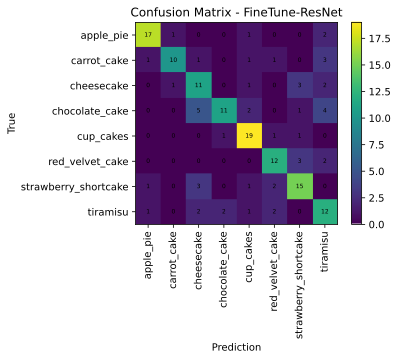

Best model misclassified samples: 53


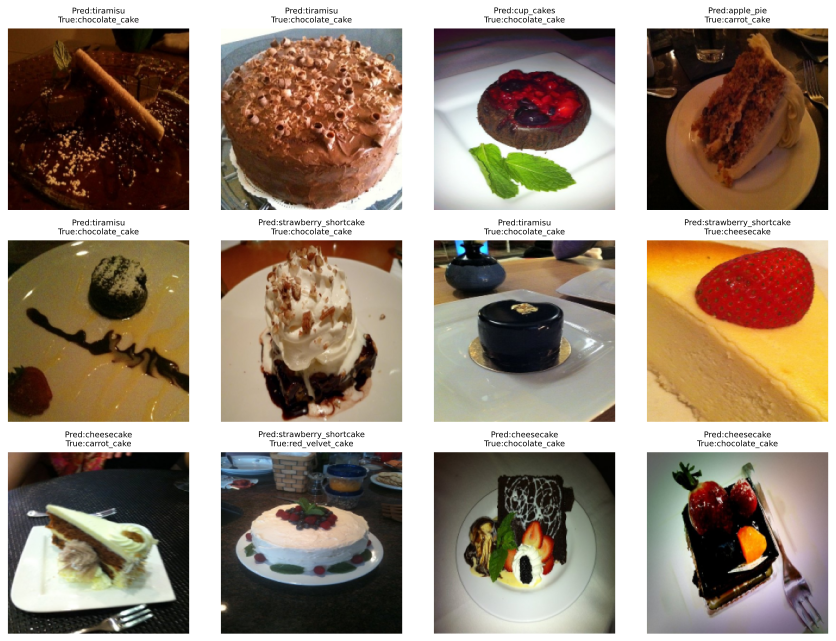

In [48]:
# 对比与可视化（修复 numpy 覆盖内置 min/max 导致的问题）
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import math

print("\n=== Model Performance Summary ===")
print(f"ResNet50 + MLP:                    {resnet_mlp_acc:.4f}")
print(f"InceptionV3 + LogisticRegression:  {inception_acc:.4f}")
print(f"ResNet Spatial 7x7 + Small CNN:    {spatial_acc:.4f}")
print(f"Fine-tune (layer4 + fc):           {best_ft_acc:.4f}")

model_scores = {
    "ResNet-MLP": resnet_mlp_acc,
    "Inception-LogReg": inception_acc,
    "Spatial-CNN": spatial_acc,
    "FineTune-ResNet": best_ft_acc
}

# 使用 sorted 而不是 max(key=...)，避免 numpy.max 覆盖内置 max 的问题
best_model_name = sorted(model_scores.items(), key=lambda kv: kv[1], reverse=True)[0][0]
print("Best model:", best_model_name)

if best_model_name == "ResNet-MLP":
    deep_mypred = resnet_mlp_pred
elif best_model_name == "Inception-LogReg":
    deep_mypred = inception_pred
elif best_model_name == "Spatial-CNN":
    deep_mypred = spatial_pred
else:
    deep_mypred = best_ft_pred

# 混淆矩阵
CM = metrics.confusion_matrix(testY, deep_mypred)
plt.figure(figsize=(6,5))
plt.imshow(CM, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Prediction"); plt.ylabel("True")
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j, i, f"{CM[i,j]}", ha='center', va='center', fontsize=6)
plt.tight_layout()
plt.show()

# 错误样本可视化（修复点：不使用 numpy.min；显式整型行列数）
mis_idx = np.where(deep_mypred != testY)[0]
print(f"Best model misclassified samples: {len(mis_idx)}")
# 避免 numpy.min 被 from numpy import * 覆盖的问题
show_n = 12 if len(mis_idx) >= 12 else int(len(mis_idx))

if show_n > 0:
    rows = (show_n + 3) // 4  # 等效于 int(math.ceil(show_n/4.0))
    cols = 4
    plt.figure(figsize=(12, 3*rows))
    for k in range(show_n):
        i = mis_idx[k]
        plt.subplot(rows, cols, k+1)
        plt.imshow(testimgdata[i])
        plt.title(f"Pred:{le.classes_[deep_mypred[i]]}\nTrue:{le.classes_[testY[i]]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


_Where you able to improve the accuracy using deep learning? Analyze the errors from your best model._

- **INSERT YOUR ANSWER HERE**